## Grupo:
## Andrea Blatter, Fernanda Pucheta, Cesar Zamboni

In [1]:
#!pip install xgboost
#!pip install seaborn 
#!pip install matplotlib

In [2]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings(action="ignore")


In [3]:
### Loading Data
data = pd.read_csv('data/base_tarjeta_credito.csv')


## Preparamos el tag y el dataset completo

In [4]:
data.head()

,Unnamed: 0,email,cliente,FechaSaldos,periodo_cli,periodo,cant_productos,cant_PF,cant_TC,cant_PP,...,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,target,target2
0,0,cliente@mail.com,0,2019-12-06 09:45:00,24240,24240,2,0,0,0,...,0,9440.56,0.00,0.0,0,4577.00,0,NaN,0.0,0.0
1,1,cliente@mail.com,1,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,5029.59,0.00,0.0,0,8813.89,0,NaN,0.0,0.0
2,2,cliente@mail.com,2,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,50156.32,0.00,0.0,0,10387.20,0,0.0,0.0,0.0
3,3,cliente@mail.com,3,2019-12-06 09:45:00,24240,24240,6,0,3,0,...,0,26082.85,0.00,0.0,0,600.00,0,1.0,0.0,0.0
4,4,cliente@mail.com,4,2019-12-06 09:45:00,24240,24240,6,1,2,0,...,0,103080.40,470.04,0.0,0,1618.19,0,0.0,0.0,1.0


In [5]:
data.columns

Index(['Unnamed: 0', 'email', 'cliente', 'FechaSaldos', 'periodo_cli',
       'periodo', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'TipoCuentaAcredHab',
       'CategoriaProducto', 'FechaVinculacion', 'cuotas_faltantes_1',
       'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target', 'target2'],
      dtype='object')

In [6]:
data['CategoriaProducto']

0         JUB00021
1         JUB00021
2         JUB00021
3         JUB00021
4         K  00021
            ...   
494882    PRI00001
494883    PRI00001
494884    PRI00001
494885    PRI00001
494886    CON00001
Name: CategoriaProducto, Length: 494887, dtype: object

In [7]:
data['target'].value_counts()

0.0    491817
1.0      3070
Name: target, dtype: int64

In [8]:
data['target2'].value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [9]:
data[data['target']==0.0]['target2'].value_counts()

0.0    318543
1.0    173274
Name: target2, dtype: int64

In [10]:
data[data['target']==1.0]['target2'].value_counts()

1.0    3070
Name: target2, dtype: int64

In [11]:
data[data['cant_TC']==0]['target'].value_counts()

0.0    99056
1.0     1196
Name: target, dtype: int64

In [12]:
#veremos el tamaño del dataset
data.shape

(494887, 44)

In [13]:
#chequeamos columnas con valores unicos
data.nunique()

Unnamed: 0                       247789
email                                 1
cliente                          247789
FechaSaldos                           3
periodo_cli                           3
periodo                               3
cant_productos                       58
cant_PF                              44
cant_TC                              25
cant_PP                               6
FechaUltMovCA                       971
cant_seguros                         18
importe_consumos                    317
Edad                                115
Sexo                                  3
SaldoPromedioCAPesos             411491
SaldoPromedioCADolares            63559
SaldoPromedioCCAcreedor           11063
TotalConsumoTD                   187122
TipoCuentaAcredHab                    1
CategoriaProducto                    28
FechaVinculacion                   5134
cuotas_faltantes_1                  271
cant_PF_ant_1                        43
cant_TC_ant_1                        25


## Análisis y transformación de datos

### Eliminamos columnas que no aportan nada

In [14]:
#tenemos columnas con un unico valor para todos los registros, a estas las eliminaremos porque no aportan valor
[x for x in data.columns if data[x].nunique()==1]

['email', 'TipoCuentaAcredHab']

In [15]:
#la columna cliente tampoco aporta nada asi que la eliminamos tmb 
to_remove = ['cliente'] + [x for x in data.columns if data[x].nunique()==1]

In [16]:
#eliminamos entonces estas columnas
data.drop(columns=to_remove,inplace=True)

### Chequeamos duplicados

In [17]:
data.duplicated().any() # chequeamos si hay duplicados de registros, si hay los borramos con drop_duplicates()

False

In [18]:
data.shape

(494887, 41)

### Chequeamos faltantes

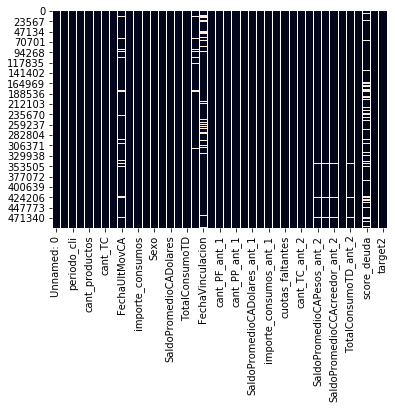

In [19]:
#haremos un heatmap para ver nulos 
sns.heatmap(data[data.columns[0:45]].isnull(), cbar=False)

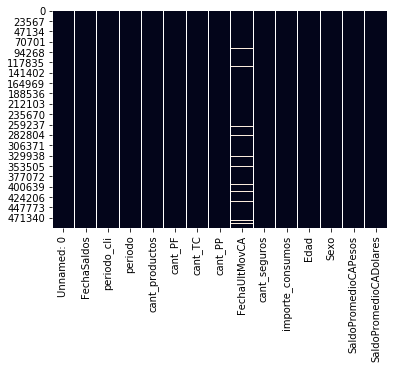

In [20]:
#no se visualiza bien asi que haremos heatmaps incluyendo menos columnas para analizar mejor 
sns.heatmap(data[data.columns[0:15]].isnull(), cbar=False)

Vemos muchos nulos en FechaUltMovCA

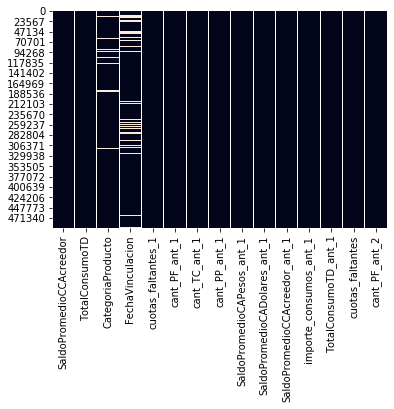

In [21]:
sns.heatmap(data[data.columns[15:30]].isnull(), cbar=False)

fecha vinculacion tiene muchos nulos tambien, la trabajaremos para ver si hay periodos no consecutivos con altas 

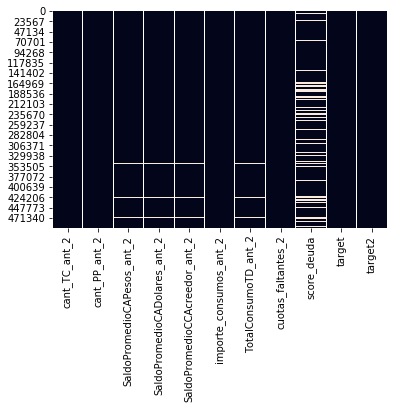

In [22]:
sns.heatmap(data[data.columns[30:45]].isnull(), cbar=False)

score deuda tiene muchos nulos tambien pero sabemos que equivalen a no tener deuda
vemos otros nulos en otras 4 columnas que son igual para todos los registros 

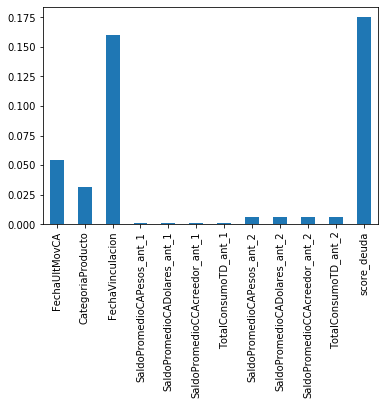

In [23]:
#contaremos la cantidad de nulos para cada columna 
nullcount = {col:data[col].isnull().sum() for col in data.columns}
#y haremos una serie con estos valores para graficarlo como grafico de barras
missing = pd.Series(nullcount)
#ahora graficamos valores relativos solamente de las variables que contienen nulos, por eso usamos div
missing[missing>0].div(data.shape[0]).plot.bar()

### Trabajaremos con fecha de vinculacion

In [24]:
data['FechaVinculacion'].dtype

dtype('O')

In [25]:
#lo primero que haremos sera convertirla a formato date
data['Date'] = pd.to_datetime(data['FechaVinculacion'])

In [26]:
#y obtendremos otros datos para trabajarla con una tabla pivot
data['Month'] = data['Date'].dt.month # obtenemos el numero de mes
data['Year'] = data['Date'].dt.year # obtenemos el año
data['Period'] = data['Date'].dt.to_period('M') # obtenemos el periodo, en formato año/mes
data.sort_values('Date', inplace=True) # ordenamos por fecha de activacion a los datos

In [27]:
#Haremos una tabla pivot usando como indice el año y como columna los meses
pd.pivot_table(data=data, 
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                           \
Month     1.0     2.0     3.0     4.0     5.0     6.0     7.0      8.0    
Year                                                                      
1990.0    26.0     NaN     NaN     NaN     NaN     NaN     NaN      NaN   
1995.0     2.0     2.0     2.0     NaN     NaN     NaN     NaN      NaN   
1996.0     NaN     NaN     3.0     NaN     NaN     NaN     NaN      NaN   
1997.0     NaN     NaN     2.0     NaN     NaN     NaN     NaN      NaN   
1998.0     NaN     NaN     NaN     2.0     NaN     NaN     NaN      NaN   
1999.0     NaN     NaN     2.0     NaN  1002.0  1966.0   943.0   1524.0   
2000.0   539.0   585.0   620.0   820.0   894.0   657.0   655.0    769.0   
2001.0   703.0   521.0   561.0   670.0   812.0   610.0   786.0    773.0   
2002.0   841.0   576.0   714.0   469.0   800.0  1023.0   710.0    661.0   
2003.0   559.0   511.0   627.0   819.0   787.0   899.0   812.0    738.0   
2004.0   647.0   711.0  1184.0  1004.0   982.0  1040.0  1104.0   1138.0   
2005.0   740.0   682.0   942.0  1523.0  1255.0  1294.0  1080.0   1143.0   
2006.0   959.0   758.0  1071.0  1261.0  1172.0  1122.0  1356.0   1150.0   
2007.0  1278.0  1001.0  1490.0  1299.0  1530.0  1627.0  1598.0   1422.0   
2008.0  1138.0   879.0   942.0  1288.0  1644.0  1270.0  1533.0   1497.0   
2009.0   676.0   696.0   883.0  1114.0  1513.0  1502.0  1372.0   1156.0   
2010.0  1092.0   882.0  8354.0  1073.0  1589.0  1872.0  1812.0   1792.0   
2011.0  1168.0  1239.0  1375.0  1595.0  2050.0  2047.0  2122.0   1884.0   
2012.0  1503.0  2305.0  2181.0  1726.0  2871.0  1885.0  1725.0   1821.0   
2013.0  1676.0  1482.0  1783.0  2020.0  2208.0  1880.0  2494.0   2352.0   
2014.0  1715.0  1635.0  1778.0  2416.0  2092.0  2105.0  2647.0   2271.0   
2015.0  1576.0  1484.0  1862.0  3031.0  2537.0  2813.0  2357.0   1813.0   
2016.0  1713.0  1799.0  2577.0  3580.0  4488.0  2933.0  3619.0   2942.0   
2017.0  3064.0  3583.0  4111.0  4525.0  4119.0  4685.0  5483.0  12074.0   
2018.0  2301.0  1875.0  2130.0  3267.0  2750.0  2598.0  2424.0   2325.0   
2019.0  2332.0  2745.0  3548.0  2589.0  1947.0  1716.0  1366.0   1053.0   
2020.0    59.0     9.0     NaN     NaN     NaN     NaN     NaN      NaN   

                                        
Month     9.0     10.0    11.0    12.0  
Year                                    
1990.0     NaN     NaN     NaN     NaN  
1995.0     5.0     NaN     NaN     NaN  
1996.0     1.0     NaN     NaN     NaN  
1997.0     NaN     NaN     NaN     NaN  
1998.0     NaN     NaN     NaN     NaN  
1999.0   999.0   759.0   602.0   541.0  
2000.0   559.0   902.0   632.0   640.0  
2001.0   856.0   757.0   715.0  1727.0  
2002.0   856.0   724.0   627.0   572.0  
2003.0  1055.0   747.0   685.0   680.0  
2004.0  1000.0   866.0  1001.0   941.0  
2005.0  1240.0  1194.0  1110.0   953.0  
2006.0  1356.0  1205.0  1234.0  1942.0  
2007.0  1232.0  1334.0  1411.0  1112.0  
2008.0  1468.0  1338.0  1055.0  1021.0  
2009.0  1517.0  1214.0  1462.0  1454.0  
2010.0  1490.0  1538.0  1526.0  1487.0  
2011.0  1870.0  1900.0  1479.0  1422.0  
2012.0  1412.0  2102.0  1971.0  1351.0  
2013.0  2406.0  2506.0  2471.0  1790.0  
2014.0  2069.0  2315.0  1738.0  1640.0  
2015.0  2156.0  2306.0  1873.0  1716.0  
2016.0  3431.0  3634.0  3571.0  2549.0  
2017.0  4046.0  3017.0  2679.0  2331.0  
2018.0  2182.0  2695.0  3751.0  2019.0  
2019.0  1240.0  1845.0  1975.0   841.0  
2020.0     NaN     NaN     NaN     NaN

In [28]:
#vemos que hay muchos periodos con valores nulos, asi que nos quedamos con los datos desde mayo del 99 en adelante
period = pd.to_datetime('1999-05').to_period('M') 

In [29]:
data = data[data['Period']>=period]

In [30]:
#veremos como quedo ahora la tabla sin los valores que eliminamos
pd.pivot_table(data,
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                           \
Month     1.0     2.0     3.0     4.0     5.0     6.0     7.0      8.0    
Year                                                                      
1999.0     NaN     NaN     NaN     NaN  1002.0  1966.0   943.0   1524.0   
2000.0   539.0   585.0   620.0   820.0   894.0   657.0   655.0    769.0   
2001.0   703.0   521.0   561.0   670.0   812.0   610.0   786.0    773.0   
2002.0   841.0   576.0   714.0   469.0   800.0  1023.0   710.0    661.0   
2003.0   559.0   511.0   627.0   819.0   787.0   899.0   812.0    738.0   
2004.0   647.0   711.0  1184.0  1004.0   982.0  1040.0  1104.0   1138.0   
2005.0   740.0   682.0   942.0  1523.0  1255.0  1294.0  1080.0   1143.0   
2006.0   959.0   758.0  1071.0  1261.0  1172.0  1122.0  1356.0   1150.0   
2007.0  1278.0  1001.0  1490.0  1299.0  1530.0  1627.0  1598.0   1422.0   
2008.0  1138.0   879.0   942.0  1288.0  1644.0  1270.0  1533.0   1497.0   
2009.0   676.0   696.0   883.0  1114.0  1513.0  1502.0  1372.0   1156.0   
2010.0  1092.0   882.0  8354.0  1073.0  1589.0  1872.0  1812.0   1792.0   
2011.0  1168.0  1239.0  1375.0  1595.0  2050.0  2047.0  2122.0   1884.0   
2012.0  1503.0  2305.0  2181.0  1726.0  2871.0  1885.0  1725.0   1821.0   
2013.0  1676.0  1482.0  1783.0  2020.0  2208.0  1880.0  2494.0   2352.0   
2014.0  1715.0  1635.0  1778.0  2416.0  2092.0  2105.0  2647.0   2271.0   
2015.0  1576.0  1484.0  1862.0  3031.0  2537.0  2813.0  2357.0   1813.0   
2016.0  1713.0  1799.0  2577.0  3580.0  4488.0  2933.0  3619.0   2942.0   
2017.0  3064.0  3583.0  4111.0  4525.0  4119.0  4685.0  5483.0  12074.0   
2018.0  2301.0  1875.0  2130.0  3267.0  2750.0  2598.0  2424.0   2325.0   
2019.0  2332.0  2745.0  3548.0  2589.0  1947.0  1716.0  1366.0   1053.0   
2020.0    59.0     9.0     NaN     NaN     NaN     NaN     NaN      NaN   

                                        
Month     9.0     10.0    11.0    12.0  
Year                                    
1999.0   999.0   759.0   602.0   541.0  
2000.0   559.0   902.0   632.0   640.0  
2001.0   856.0   757.0   715.0  1727.0  
2002.0   856.0   724.0   627.0   572.0  
2003.0  1055.0   747.0   685.0   680.0  
2004.0  1000.0   866.0  1001.0   941.0  
2005.0  1240.0  1194.0  1110.0   953.0  
2006.0  1356.0  1205.0  1234.0  1942.0  
2007.0  1232.0  1334.0  1411.0  1112.0  
2008.0  1468.0  1338.0  1055.0  1021.0  
2009.0  1517.0  1214.0  1462.0  1454.0  
2010.0  1490.0  1538.0  1526.0  1487.0  
2011.0  1870.0  1900.0  1479.0  1422.0  
2012.0  1412.0  2102.0  1971.0  1351.0  
2013.0  2406.0  2506.0  2471.0  1790.0  
2014.0  2069.0  2315.0  1738.0  1640.0  
2015.0  2156.0  2306.0  1873.0  1716.0  
2016.0  3431.0  3634.0  3571.0  2549.0  
2017.0  4046.0  3017.0  2679.0  2331.0  
2018.0  2182.0  2695.0  3751.0  2019.0  
2019.0  1240.0  1845.0  1975.0   841.0  
2020.0     NaN     NaN     NaN     NaN

In [31]:
#ahora vemos que en la tabla quedaron muchos valores nulos (los Nan) a estos los reemplazaremos por 0
#con el argumento fill_value
pivot_table = pd.pivot_table(data,
                               index=['Year'],
                               columns=['Month'],
                               aggfunc=['size'],
                               fill_value=0 # le asignamos un valor a los nan
                              )
pivot_table

size                                                               \
Month   1.0   2.0   3.0   4.0   5.0   6.0   7.0    8.0   9.0   10.0  11.0   
Year                                                                        
1999.0     0     0     0     0  1002  1966   943   1524   999   759   602   
2000.0   539   585   620   820   894   657   655    769   559   902   632   
2001.0   703   521   561   670   812   610   786    773   856   757   715   
2002.0   841   576   714   469   800  1023   710    661   856   724   627   
2003.0   559   511   627   819   787   899   812    738  1055   747   685   
2004.0   647   711  1184  1004   982  1040  1104   1138  1000   866  1001   
2005.0   740   682   942  1523  1255  1294  1080   1143  1240  1194  1110   
2006.0   959   758  1071  1261  1172  1122  1356   1150  1356  1205  1234   
2007.0  1278  1001  1490  1299  1530  1627  1598   1422  1232  1334  1411   
2008.0  1138   879   942  1288  1644  1270  1533   1497  1468  1338  1055   
2009.0   676   696   883  1114  1513  1502  1372   1156  1517  1214  1462   
2010.0  1092   882  8354  1073  1589  1872  1812   1792  1490  1538  1526   
2011.0  1168  1239  1375  1595  2050  2047  2122   1884  1870  1900  1479   
2012.0  1503  2305  2181  1726  2871  1885  1725   1821  1412  2102  1971   
2013.0  1676  1482  1783  2020  2208  1880  2494   2352  2406  2506  2471   
2014.0  1715  1635  1778  2416  2092  2105  2647   2271  2069  2315  1738   
2015.0  1576  1484  1862  3031  2537  2813  2357   1813  2156  2306  1873   
2016.0  1713  1799  2577  3580  4488  2933  3619   2942  3431  3634  3571   
2017.0  3064  3583  4111  4525  4119  4685  5483  12074  4046  3017  2679   
2018.0  2301  1875  2130  3267  2750  2598  2424   2325  2182  2695  3751   
2019.0  2332  2745  3548  2589  1947  1716  1366   1053  1240  1845  1975   
2020.0    59     9     0     0     0     0     0      0     0     0     0   

              
Month   12.0  
Year          
1999.0   541  
2000.0   640  
2001.0  1727  
2002.0   572  
2003.0   680  
2004.0   941  
2005.0   953  
2006.0  1942  
2007.0  1112  
2008.0  1021  
2009.0  1454  
2010.0  1487  
2011.0  1422  
2012.0  1351  
2013.0  1790  
2014.0  1640  
2015.0  1716  
2016.0  2549  
2017.0  2331  
2018.0  2019  
2019.0   841  
2020.0     0

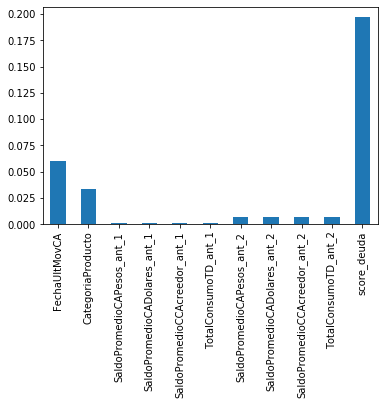

In [32]:
#vamos a volver a ver los valores nulos como quedaron luego de eliminar estos registros  
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

In [33]:
#los valores nulos que vemos en score_deuda es lo mismo que decir que el cliente no posea deudas
#asi que a los nulos los pasaremos a 1 , y a los valores que sean 0 tambien los pasaremos a 1 
data.loc[data['score_deuda'].isnull(),'score_deuda']=1

In [34]:
data.loc[data['score_deuda']==0,'score_deuda']=1

In [35]:
#eliminaremos los nulos de la columna SaldoPromedioCAPesos_ant_2 y veremos si asi eliminamos los nulos de las otras 3 columnas
#relacionadas a ant_2 tmb 
data.drop(data[data['SaldoPromedioCAPesos_ant_2'].isnull()].index, inplace = True)

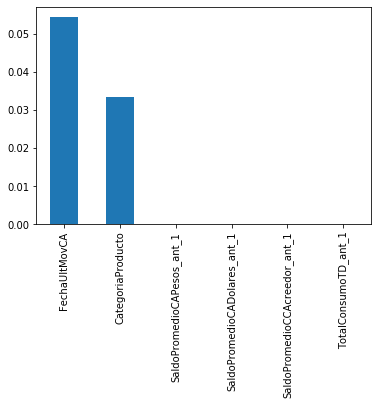

In [36]:
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

In [37]:
#efectivamente eliminamos esos nulos y ahora haremos lo mismo con las columnas relacionadas a ant1 
data.drop(data[data['SaldoPromedioCAPesos_ant_1'].isnull()].index, inplace = True)

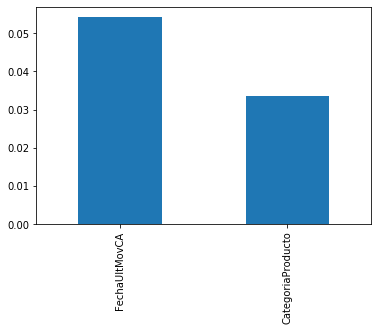

In [38]:
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

Vemos que ahora solo tenemos 2 columnas que poseen muchos registros nulos, trabajaremos ahora con FechaUltMovCA

In [39]:
data['FechaUltMovCA'].dtype

dtype('O')

In [40]:
#lo primero que haremos sera convertirla a formato date
data['DateUltMov'] = pd.to_datetime(data['FechaUltMovCA'])

In [41]:
#y obtendremos otros datos para trabajarla con una tabla pivot
data['MonthUltMov'] = data['DateUltMov'].dt.month # obtenemos el numero de mes
data['YearUltMov'] = data['DateUltMov'].dt.year # obtenemos el año
data['PeriodUltMov'] = data['DateUltMov'].dt.to_period('M') # obtenemos el periodo, en formato año/mes
data.sort_values('DateUltMov', inplace=True) # ordenamos por fecha de activacion a los datos

In [42]:
#Haremos una tabla pivot usando como indice el año y como columna los meses
pd.pivot_table(data=data, 
               index=['YearUltMov'],
               columns=['MonthUltMov'],
               aggfunc=['size']
              )

size                                                    \
MonthUltMov    1.0      2.0     3.0     4.0     5.0     6.0      7.0    
YearUltMov                                                              
2004.0          NaN      NaN     NaN     2.0     NaN     NaN      NaN   
2006.0          NaN      NaN     NaN     2.0     NaN     NaN      NaN   
2007.0          NaN      NaN     3.0     NaN     NaN     NaN      NaN   
2008.0          2.0      NaN     NaN     2.0     NaN     NaN      NaN   
2009.0          NaN      NaN     NaN     NaN     2.0     NaN      1.0   
2010.0          NaN      NaN     4.0     NaN     7.0     NaN      2.0   
2011.0          NaN      4.0     6.0     2.0     1.0     NaN      3.0   
2012.0          2.0      2.0     3.0     1.0     2.0     3.0      2.0   
2013.0          5.0      4.0     2.0     7.0     6.0     1.0      7.0   
2014.0          2.0      5.0     7.0     3.0     8.0     7.0     11.0   
2015.0          4.0      3.0     2.0     4.0     7.0     6.0      8.0   
2016.0          5.0      4.0     5.0     6.0     8.0     9.0     12.0   
2017.0         17.0     28.0   619.0   367.0   467.0   350.0    454.0   
2018.0        595.0    378.0   488.0   578.0   726.0   657.0    601.0   
2019.0       5326.0  84766.0  5094.0  5321.0  6202.0  6380.0  10746.0   
2020.0       2572.0   3058.0     NaN     NaN     NaN     NaN      NaN   

                                                          
MonthUltMov     8.0      9.0     10.0     11.0      12.0  
YearUltMov                                                
2004.0           NaN      NaN     NaN      NaN       NaN  
2006.0           NaN      NaN     NaN      NaN       NaN  
2007.0           NaN      NaN     NaN      NaN       NaN  
2008.0           NaN      NaN     NaN      1.0       NaN  
2009.0           2.0      NaN     NaN      3.0       1.0  
2010.0           2.0      8.0     8.0      5.0      17.0  
2011.0           5.0      5.0     4.0     10.0       6.0  
2012.0           7.0      2.0     4.0      2.0      11.0  
2013.0           2.0      3.0     2.0      2.0       2.0  
2014.0           6.0      6.0     7.0      2.0      10.0  
2015.0           9.0      2.0     4.0      7.0       3.0  
2016.0          12.0     10.0     7.0     11.0       9.0  
2017.0         523.0    516.0   403.0    412.0     410.0  
2018.0         784.0    735.0  1068.0   2676.0    1185.0  
2019.0       18766.0  38347.0  1486.0  34515.0  152271.0  
2020.0           NaN      NaN     NaN      NaN       NaN

Vemos que tenemos muchos periodos consecutivos con nulos, asi que tomaremos la decision de eliminarlos y quedarnos con los datos de julio del 2011 en adelante, y alos valores NaN que vemos en el 2020 los reemplazaremos por 0 

In [43]:
#veremos como queda el dataset antes y despues de eliminar estos registros
data.shape

(412729, 49)

In [44]:
period = pd.to_datetime('2011-07').to_period('M') 
data = data[data['PeriodUltMov']>=period]

In [45]:
pivot_table = pd.pivot_table(data,
                               index=['YearUltMov'],
                               columns=['MonthUltMov'],
                               aggfunc=['size'],
                               fill_value=0 # le asignamos un valor a los nan
                              )
pivot_table

size                                                            \
MonthUltMov  1.0    2.0   3.0   4.0   5.0   6.0    7.0    8.0    9.0   10.0   
YearUltMov                                                                    
2011.0          0      0     0     0     0     0      3      5      5     4   
2012.0          2      2     3     1     2     3      2      7      2     4   
2013.0          5      4     2     7     6     1      7      2      3     2   
2014.0          2      5     7     3     8     7     11      6      6     7   
2015.0          4      3     2     4     7     6      8      9      2     4   
2016.0          5      4     5     6     8     9     12     12     10     7   
2017.0         17     28   619   367   467   350    454    523    516   403   
2018.0        595    378   488   578   726   657    601    784    735  1068   
2019.0       5326  84766  5094  5321  6202  6380  10746  18766  38347  1486   
2020.0       2572   3058     0     0     0     0      0      0      0     0   

                            
MonthUltMov   11.0    12.0  
YearUltMov                  
2011.0          10       6  
2012.0           2      11  
2013.0           2       2  
2014.0           2      10  
2015.0           7       3  
2016.0          11       9  
2017.0         412     410  
2018.0        2676    1185  
2019.0       34515  152271  
2020.0           0       0

In [46]:
data.shape

(390235, 49)

In [47]:
#todas las columnas de date que hemos agregado podemos eliminarlas ahora
to_remove = ["Date", "Month", "Year", "Period", "DateUltMov", "MonthUltMov", "YearUltMov", "PeriodUltMov"]

In [48]:
data.drop(columns=to_remove,inplace=True)

In [49]:
data.shape

(390235, 41)

Ahora solo nos queda trabajar con categoria producto

In [50]:
data['CategoriaProducto'].value_counts(normalize=True,dropna=False)

K  00021    0.517693
GRL00003    0.227486
JUB00021    0.181442
PC200003    0.024765
PC100003    0.018169
NaN         0.005494
CCL00003    0.004244
L  00021    0.003552
GRA00001    0.003219
SUB00003    0.003206
PRI00001    0.003170
WEB00003    0.002834
DNI00003    0.001399
LIB00003    0.001225
CON00001    0.000648
PRI00018    0.000482
RED00003    0.000323
PC100001    0.000223
PC300003    0.000097
COF00001    0.000090
JOV00003    0.000077
K  00001    0.000044
ADO00003    0.000041
COE00001    0.000028
Q  00003    0.000021
FIU00003    0.000013
PIG00003    0.000010
BSU00003    0.000008
Name: CategoriaProducto, dtype: float64

In [51]:
#vemos que hay un gran porcentaje (mas del 51%) de valores que pertenecen a la categoria K 00021, asi que lo que haremos 
#sera imputar los nulos reemplazandolos con ese valor 
data.loc[data['CategoriaProducto'].isnull(),'CategoriaProducto']='K  00021'

In [52]:
data['CategoriaProducto'].value_counts(normalize=True)

K  00021    0.523187
GRL00003    0.227486
JUB00021    0.181442
PC200003    0.024765
PC100003    0.018169
CCL00003    0.004244
L  00021    0.003552
GRA00001    0.003219
SUB00003    0.003206
PRI00001    0.003170
WEB00003    0.002834
DNI00003    0.001399
LIB00003    0.001225
CON00001    0.000648
PRI00018    0.000482
RED00003    0.000323
PC100001    0.000223
PC300003    0.000097
COF00001    0.000090
JOV00003    0.000077
K  00001    0.000044
ADO00003    0.000041
COE00001    0.000028
Q  00003    0.000021
FIU00003    0.000013
PIG00003    0.000010
BSU00003    0.000008
Name: CategoriaProducto, dtype: float64

### Otras transformaciones

In [53]:
data['target'].value_counts(normalize=True,dropna=False)

0.0    0.994296
1.0    0.005704
Name: target, dtype: float64

In [54]:
data['target2'].value_counts(normalize=True,dropna=False)

0.0    0.660335
1.0    0.339665
Name: target2, dtype: float64

Como tenemos muchos mas 1s en target2 que en target podemos deducir que la columna de target2 es la que refiere a si el cliente abrio o no el mail y el target a si efectivamente quiso la tarjeta

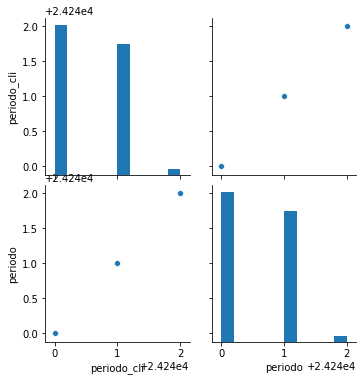

In [55]:
#Comparacion entre  periodo_cli y  periodo
for_pairplot= data[["periodo_cli", "periodo"]]
for_pairplot=for_pairplot.sample(1000)
sns.pairplot(for_pairplot)

In [56]:
#vemos que son exactamente iguales estas columnas por lo que eliminamos una de ellas 
data.drop(columns="periodo_cli", inplace=True)

### Analizaremos valores faltantes o erróneos

In [57]:
data.columns

Index(['Unnamed: 0', 'FechaSaldos', 'periodo', 'cant_productos', 'cant_PF',
       'cant_TC', 'cant_PP', 'FechaUltMovCA', 'cant_seguros',
       'importe_consumos', 'Edad', 'Sexo', 'SaldoPromedioCAPesos',
       'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'TotalConsumoTD',
       'CategoriaProducto', 'FechaVinculacion', 'cuotas_faltantes_1',
       'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target', 'target2'],
      dtype='object')

In [58]:
data['FechaSaldos'].value_counts()
#vemos solo 3 fecha de saldos.. sera una fecha de corte? 

2019-12-06 09:45:00    201331
2020-01-08 09:48:00    180435
2020-02-07 14:13:00      8469
Name: FechaSaldos, dtype: int64

In [59]:
data['periodo'].value_counts()

24240    201331
24241    180435
24242      8469
Name: periodo, dtype: int64

In [60]:
#tambien solo hay 3 tipos de periodos, igual que para fecha de saldos. de estas 2 podemos quedarnos solo con una columna
#en tal caso preferiria quedarme con la columna que indica la fecha de saldos ya que posee mas informacion que el nro del periodo
data.drop(columns="periodo", inplace=True)

In [61]:
data['cant_productos'].value_counts()
#vemos que sin duda tenemos valores outliers en esta columna y de la misma manera podemos tener en cant_PF, cant_TC, cant_PP etc

3      108674
2       91142
4       78231
5       40797
1       38009
6       18316
7        8122
8        3488
9        1525
10        848
11        391
12        208
13        177
14         86
15         52
16         40
17         29
20         14
19         11
18          9
26          6
103         6
23          6
22          6
27          4
25          4
21          4
29          3
104         3
0           2
24          2
30          2
36          2
41          2
101         2
102         2
106         1
31          1
39          1
42          1
43          1
46          1
77          1
93          1
105         1
213         1
Name: cant_productos, dtype: int64

In [62]:
data['Edad'].value_counts()

39     11772
37     11764
38     11747
35     11665
34     11601
       ...  
106        4
117        2
114        2
113        2
111        2
Name: Edad, Length: 115, dtype: int64

In [63]:
#vemos que hay muchas edades que estan por encima de los 100, no tienen sentido asi que las reemplazaremos por la edad promedio
data['Edad'].describe()

count    390235.000000
mean         47.148669
std          17.616954
min           0.000000
25%          34.000000
50%          43.000000
75%          58.000000
max         119.000000
Name: Edad, dtype: float64

In [64]:
data.loc[data['Edad']>=100,'Edad']=47

In [65]:
#haremos lo mismo para los que tengan menos de 18 años 
data.loc[data['Edad']<18,'Edad']=47

In [66]:
data['Edad'].describe()
#nos queda asi la edad minima de 18 años y la maxima de 99, tiene mas sentido de esta forma.. 

count    390235.000000
mean         47.233598
std          17.340858
min          18.000000
25%          34.000000
50%          43.000000
75%          58.000000
max          99.000000
Name: Edad, dtype: float64

In [67]:
data['Sexo'].value_counts()

F    215600
M    172944
       1691
Name: Sexo, dtype: int64

In [68]:
#tenemos muchos valores con string vacio, podemos eliminar estos registros o considerar que se refiere a una cuenta 
#de tipo juridica y por eso no tiene sexo

### Corrección de valores outliers

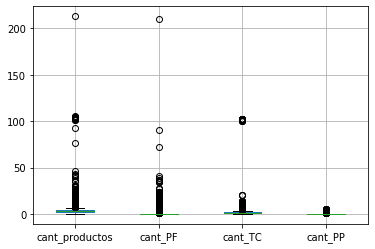

In [69]:
#Analizaremos las variables cant_productos, cant_PF, cant_TC y cant_PP en busca de valores outliers
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

In [70]:
#vemos que para cant_PP no tenemos valores outliers pero para las otras 3 columnas si, entonces los eliminaremos
data.loc[data['cant_productos']>data['cant_productos'].quantile(0.99),'cant_productos'] = data['cant_productos'].quantile(0.99)

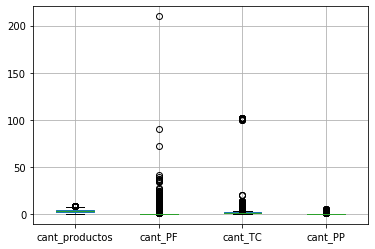

In [71]:
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

In [72]:
data.loc[data['cant_PF']>data['cant_PF'].quantile(0.99),'cant_PF'] = data['cant_PF'].quantile(0.99)

In [73]:
data.loc[data['cant_TC']>data['cant_TC'].quantile(0.99),'cant_TC'] = data['cant_TC'].quantile(0.99)

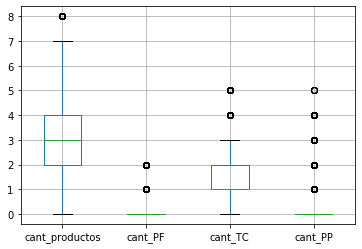

In [74]:
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

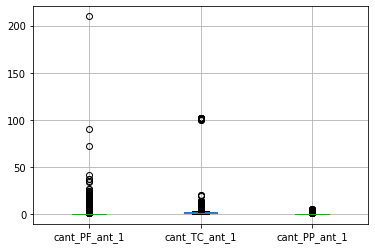

In [75]:
#realizaremos el mismo analisis para cantidades de ant 1 y eliminaremos outliers
data.boxplot(['cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1'])

In [76]:
data.loc[data['cant_PF_ant_1']>data['cant_PF_ant_1'].quantile(0.99),'cant_PF_ant_1'] = data['cant_PF_ant_1'].quantile(0.99)

In [77]:
data.loc[data['cant_TC_ant_1']>data['cant_TC_ant_1'].quantile(0.99),'cant_TC_ant_1'] = data['cant_TC_ant_1'].quantile(0.99)

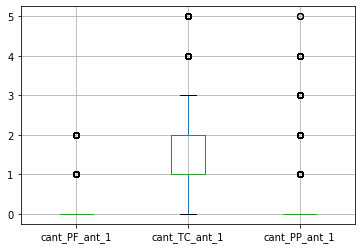

In [78]:
data.boxplot(['cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1'])

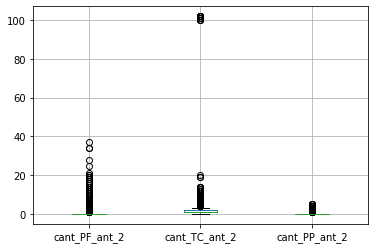

In [79]:
#por ultimo haremos el mismo analisis para las cantidades de ant 2
data.boxplot(['cant_PF_ant_2', 'cant_TC_ant_2', 'cant_PP_ant_2'])

In [80]:
#en este caso eliminaremos solo la cantidad de tarjetas de creditos y no la cantidad de plazos fijos pq sino nos quedariamos con poca info
data.loc[data['cant_TC_ant_2']>data['cant_TC_ant_2'].quantile(0.99),'cant_TC_ant_2'] = data['cant_TC_ant_2'].quantile(0.99)

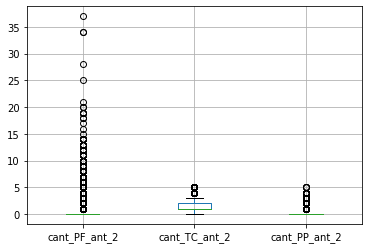

In [81]:
data.boxplot(['cant_PF_ant_2', 'cant_TC_ant_2', 'cant_PP_ant_2'])

In [82]:
data.shape

(390235, 39)

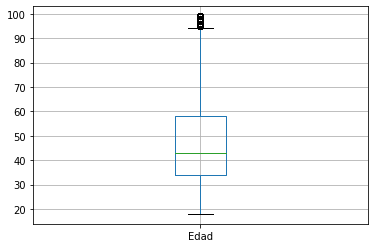

In [83]:
data.boxplot(['Edad'])

## Entrenamiento del modelo

In [84]:
#Nuestro tag estara dado por la columna target2, al que llamaremos y 
y = data['target2']

In [85]:
#tendremos en cuenta solo las columnas numericas
data = data.select_dtypes(include=['int64','float64'])

In [86]:
data.columns

Index(['Unnamed: 0', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'cant_seguros', 'importe_consumos', 'Edad', 'SaldoPromedioCAPesos',
       'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'TotalConsumoTD',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target', 'target2'],
      dtype='object')

Ahora tenemos que crear la variable x que contendra la informacion para el entrenamiento del modelo (data)

Eliminaremos tambien las columnas unnamed 0 y target y target 2

In [87]:
columns = [col for col in data.columns if col not in ['Unnamed: 0', 'target', 'target2']]
columns

['cant_productos',
 'cant_PF',
 'cant_TC',
 'cant_PP',
 'cant_seguros',
 'importe_consumos',
 'Edad',
 'SaldoPromedioCAPesos',
 'SaldoPromedioCADolares',
 'SaldoPromedioCCAcreedor',
 'TotalConsumoTD',
 'cuotas_faltantes_1',
 'cant_PF_ant_1',
 'cant_TC_ant_1',
 'cant_PP_ant_1',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'importe_consumos_ant_1',
 'TotalConsumoTD_ant_1',
 'cuotas_faltantes',
 'cant_PF_ant_2',
 'cant_TC_ant_2',
 'cant_PP_ant_2',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'importe_consumos_ant_2',
 'TotalConsumoTD_ant_2',
 'cuotas_faltantes_2',
 'score_deuda']

In [88]:
X = data[columns]

In [89]:
#ahora nos quedamos con los valores de cada variable
#values pasa de serie a array
y = y.values
X = X.values

Ahora que tenemos las dos variables X e y, debemos realizar una division del dataset en un dataset de entrenamiento y uno de testeo

Usaremos el metodo Train Test Split, el cual se encarga de dividir nuestro conjunto original en un conjunto de entrenamiento y un conjunto de testeo

In [90]:
from sklearn.model_selection import train_test_split # cargamos el metodo

In [91]:
#Separamos el conjunto entrenamiento y test con el metodo train_test_split y se lo asignamos a las distintas variables
X_train, X_test, y_train, y_test = train_test_split(X,y)
#por default el conjunto se separara en 75% para el train y 25% para el test

In [92]:
X.shape

(390235, 31)

In [93]:
X_train.shape

(292676, 31)

In [94]:
X_test.shape

(97559, 31)

Podemos observar que como separamos la variable X en train y test, la suma de registros de X_train y X_test 
dara la cantidad de registros de X. En el caso de la variable y ocurriria exactamente igual.

A su vez, X_train tendra la misma cantidad de registros o filas que y_train, y X_test la misma que y_test.

In [95]:
#utilizaremos xgboost como modelo predictivo
!pip install xgboost

In [96]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#estas herramientas nos permiten calcular metricas del modelo 

In [97]:
def train(X_train,y_train):
    """
    Función para entrenar el modelo.
    
    Parameters
    -----------
    
    X_train: pd.DataFrame
        Dataset de Train, listo para entrenar y sin tag
        
    y_train: pd.DataFrame
        Dataset de tag, es el tag correspondiente al dataset de train.
        
    Return
    ----------
    Modelo Entrenado.
    
    """
    xgb_model = xgb.XGBClassifier()
    #instanciamos el clasificador xgb
    
    print("Comienza entrenamiento del modelo XGBoost")

    xgb_model.fit(X_train, y_train)
    #el metodo fit llama al modelo matematico que entrenara el modelo 
    #xgb model ahora va a ser un modelo entrenado
    
    print("Entrenamiento finalizado\n")

    print("Haciendo las predicciones\n\n")

    #con este modelo ya entrenado llamo al metodo predict
    XGB_preds = xgb_model.predict(X_test)
    #comparo mis predicciones con el valor real que tengo guardo en y_test 
    print(classification_report(y_test, XGB_preds))
    print(confusion_matrix(y_test, XGB_preds))
    return xgb_model

In [98]:
def predict(data_to_predict, xgb_model):
    """Funcion para hacer el entrenamiento del modelo y guardarlo en un archivo .pkl

    Parameters
    -----------

    data_to_predict : pd.DataFrame
        DataFrame listo para predecir, con las mismas transformaciones que el de entrenamiento.
        
    xgb_model : xgb.XGBClassifier
        Modelo entrenado de XGBoost

    Return
    -----------
    Dataframe de 3 columnas, la identificacion del cliente, la prediccion de la clase y la probabilidad de que el cliente
    permanezca en el servicio.


    """
    print("\n\n-------------------------")
    print("Ingreso a la funcion de prediccion\n")

    XGB_preds = xgb_model.predict_proba(X)
    #si en vez de un predict proba hacemos un predict nos daria como resultado 0 y 1 directamente, redondeando
    
    return XGB_preds

In [99]:
modelo = train(X_train, y_train)

Comienza entrenamiento del modelo XGBoost
Entrenamiento finalizado

Haciendo las predicciones


              precision    recall  f1-score   support

         0.0       0.67      0.97      0.79     64451
         1.0       0.51      0.07      0.12     33108

    accuracy                           0.66     97559
   macro avg       0.59      0.52      0.46     97559
weighted avg       0.62      0.66      0.56     97559

[[62250  2201]
 [30802  2306]]


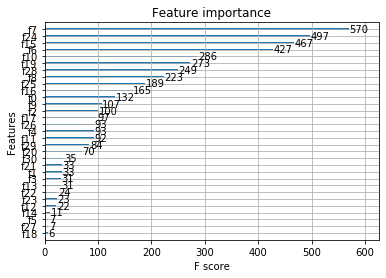

In [100]:
from xgboost import plot_importance
plot_importance(modelo, )

In [101]:
resultado = predict(X_test,modelo)



-------------------------
Ingreso a la funcion de prediccion



In [102]:
resultado
#podemos ver un array con las probabilidades de que cada registro valga 0 o 1

array([[0.4799183 , 0.5200817 ],
       [0.6401422 , 0.3598578 ],
       [0.6401422 , 0.3598578 ],
       ...,
       [0.82580125, 0.17419876],
       [0.5335233 , 0.46647668],
       [0.7488476 , 0.25115243]], dtype=float32)

In [103]:
resultado = pd.DataFrame(resultado)

In [104]:
resultado.describe()

,0,1
count,390235.000000,390235.000000
mean,0.660100,0.339892
std,0.093634,0.093634
min,0.022756,0.016078
25%,0.605049,0.282642
50%,0.662801,0.337199
75%,0.717358,0.394951
max,0.983922,0.977244


In [105]:
#podriamos determinar por ejemplo que tengan 1 aquellos que tengan un valor de probabilidad mayor a 0.6 
(resultado[1] > 0.6).astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
390230    0
390231    0
390232    0
390233    0
390234    0
Name: 1, Length: 390235, dtype: int32

In [106]:
#pd.DataFrame((resultado[1] > 0.6).astype(int)).to_csv('resultado.csv')